# META Monte Carlo Simulation

### Table of Contents

- [**Parameter Extraction From Excel & Standard Deviation Assumptions**](#params)
    - [Function : Random Normal Variable for WACC and Terminal Growth Rate](#function1)
    - [Function : Calculate Implied Stock Price and Enterprise Value](#function2)
- [**Monte Carlo Simulation**](#Monte)
- [**Visualizations**](#Visualizations)
    - [Histograms of Implied Enterpirse Value and Implied Stock Price](#histogram)
     - [Quantiles ](#quantiles)
- [**Output vs Inputs**](#scatter)
- [**Multiple Linear Regression**](#regression)
- [**Actuals Vs Predicted Values Plot Linear Regression**](#residuals)
- [**Multiple Polynomial Regression**](#poli)
- [**Actuals Vs Predicted Values Plot Polynomial Regression**](#poliresiduals)


## Imports

In [1]:
import xlwings as xw
import pandas as pd
import random as rand
import numpy_financial as npf
from dataclasses import dataclass
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
plt.style.use("seaborn-dark")

# <a id='params'>Parameter Extraction From Excel & Standard Deviation Assumptions</a>

Below we connect to the DCF Model in Excel. From this Model we will extract all the relevant information necessary to run the monte Carlo Simulation.

In [2]:
operating_model = xw.Book("Meta Operating Model V.1.xlsx")
dcf_sheet = operating_model.sheets['DCF']

Below we create a data class which will extract all relevant values needed for calculating the Implied Stock Price From the DCF Model. We Also define assumptions for the WACC and Terminal Growth Rate. These two rates will be normally distributed for n iterations to analyze their effect on the Implied Stock price.

In [3]:
@dataclass
class Model:
    wacc_expected_value :float = dcf_sheet.range('E16').value
    terminal_growth_rate_expected_value :float = dcf_sheet.range('E17').value
    free_cash_flows_to_firm  = dcf_sheet.range('D33:H33').value
    cash_cash_equivalents :float = dcf_sheet.range('H49').value
    marketable_sec :float = dcf_sheet.range('H50').value
    long_term_debt :float = dcf_sheet.range('H51').value
    shares_out_standing :float = dcf_sheet.range('H53').value
    wacc_stdev :float = 0.0125
    terminal_growth_rate_stdev :float = 0.005

Below we create an instance of the Model class which will be used mainly as a function parameter nad easy way access properties from the data class

In [4]:
data = Model()

### <a id='function1'>Function for Normal Random Variables : Terminal Growth Rate and WACC</a>

In [5]:
def rand_wacc(data) :
    return rand.normalvariate(data.wacc_expected_value,data.wacc_stdev)

def rand_tgr (data) :
    return rand.normalvariate(data.terminal_growth_rate_expected_value,data.terminal_growth_rate_stdev)

### <a id='function2'>Function(s) for Calculating Implied Enterprise Value and Stock Price With Model Data</a>

Below are the functions which will be utilized to run the simulations. The Functions below are built to reflect the current Excel Model Out put to confirm that it is functioning as intended. Later These functions will be modified to expect random values for the WACC and Terminal Growth Rate.

In [6]:
def implied_enterprise_value (data):
    g_rate = data.terminal_growth_rate_expected_value
    wacc = data.wacc_expected_value
    new_fcff_list = [x for x in data.free_cash_flows_to_firm]
    terminal_value = (new_fcff_list[-1]*(1+g_rate)/(wacc - g_rate))
    new_fcff_list[-1] = new_fcff_list[-1]+ terminal_value
    enterprise_value = npf.npv(wacc,[0] + new_fcff_list)
    return enterprise_value
implied_enterprise_value(data)

300495.86207288445

In [7]:
def implied_stock_price (data):
    enterpise_val = implied_enterprise_value (data)
    cash_equiv = data.cash_cash_equivalents
    mark_sec = data.marketable_sec
    debt = data.long_term_debt
    shares= data.shares_out_standing
    stock_price = (enterpise_val + cash_equiv+mark_sec+debt)/shares
    return stock_price
implied_stock_price (data)

122.61689936080106

# <a id='Monte'>Monte Carlo Simulation</a>

In [8]:
n_iterations = 10000

In [9]:
def enterprise_value_stock_price(data):
    table = []
    for i in range(n_iterations):
        g_rate = rand_tgr(data)
        wacc = rand_wacc (data)
        new_fcff_list = [x for x in data.free_cash_flows_to_firm]
        terminal_value = (new_fcff_list[-1]*(1+g_rate)/(wacc - g_rate))
        new_fcff_list[-1] = new_fcff_list[-1]+ terminal_value
        enterprise_value = npf.npv(wacc,[0] + new_fcff_list)
        
        cash_equiv = data.cash_cash_equivalents
        mark_sec = data.marketable_sec
        debt = data.long_term_debt
        shares= data.shares_out_standing
        stock_price = (enterprise_value + cash_equiv+mark_sec+debt)/shares
        
        table.append((wacc,g_rate,enterprise_value,stock_price))
    
    df = pd.DataFrame(table,columns=["WACC","Terminal Growth Rate", "Implied Enterprise Value","Implied Stock Price"])
    return df
    
monte_carlo_df = enterprise_value_stock_price(data)
monte_carlo_df

,WACC,Terminal Growth Rate,Implied Enterprise Value,Implied Stock Price
0,0.114563,0.029197,270624.786767,111.561727
1,0.102833,0.034133,334823.635588,135.321479
2,0.110299,0.026583,278707.165806,114.552985
3,0.087878,0.029268,402154.088166,160.240225
4,0.098981,0.037272,370675.531683,148.590130
...,...,...,...,...
9995,0.104984,0.032044,316611.346058,128.581179
9996,0.099263,0.024606,316800.731826,128.651270
9997,0.119122,0.030125,258110.880668,106.930378
9998,0.097420,0.026349,331742.547689,134.181180


## <a id='Visualizations'>Visualizations</a>

In [10]:
def styled_df(df):
    return df.style.format({
        'WACC': '{:.2%}',
        'Terminal Growth Rate': '{:.2%}',
        'Implied Enterprise Value': '${:,.2f}',
        'Implied Stock Price': '${:,.2f}'
    }).background_gradient(cmap='RdYlGn',subset=['Implied Stock Price'])

In [11]:
styled_df(monte_carlo_df.head(10))

,WACC,Terminal Growth Rate,Implied Enterprise Value,Implied Stock Price
0,11.46%,2.92%,"$270,624.79",$111.56
1,10.28%,3.41%,"$334,823.64",$135.32
2,11.03%,2.66%,"$278,707.17",$114.55
3,8.79%,2.93%,"$402,154.09",$160.24
4,9.90%,3.73%,"$370,675.53",$148.59
5,11.21%,3.45%,"$293,977.53",$120.20
6,10.18%,2.81%,"$317,232.21",$128.81
7,10.43%,3.13%,"$317,200.33",$128.80
8,10.69%,3.15%,"$306,302.28",$124.77
9,10.74%,2.05%,"$273,349.46",$112.57


# <a id='histogram'>Histograms </a>

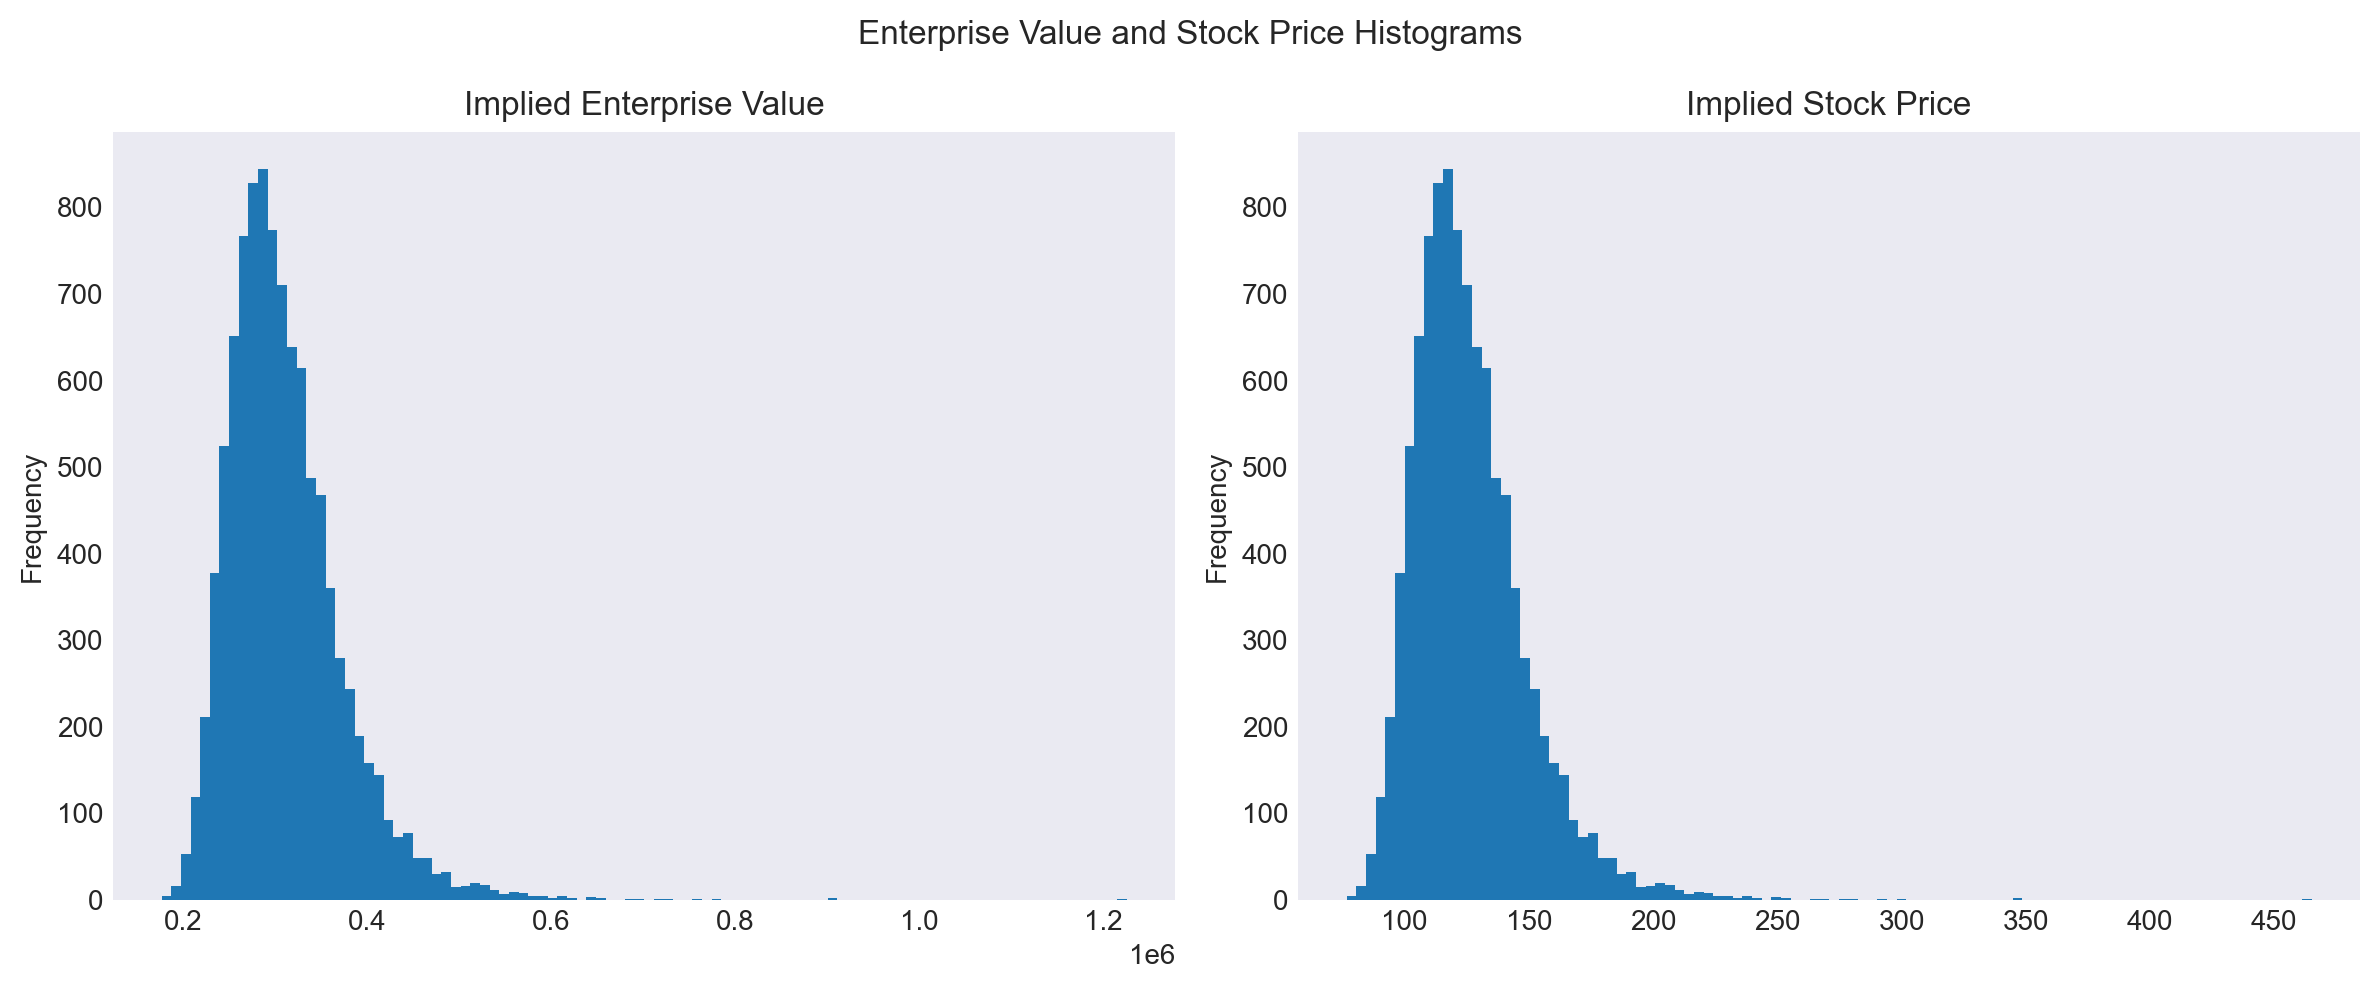

In [12]:
plt.figure(figsize=(12,5),dpi=200)
plt.suptitle("Enterprise Value and Stock Price Histograms")

plt.subplot(1,2,1)
monte_carlo_df["Implied Enterprise Value"].plot(kind="hist",bins = 100)
plt.title("Implied Enterprise Value")

plt.subplot(1,2,2)
monte_carlo_df["Implied Stock Price"].plot(kind="hist", bins = 100)
plt.title("Implied Stock Price")

plt.tight_layout()

## <a id='quantiles'>Quantiles</a>

In [13]:
quantile = monte_carlo_df.quantile([i / 20 for i in range(1, 20)])
styled_df(quantile)

,WACC,Terminal Growth Rate,Implied Enterprise Value,Implied Stock Price
0.050000,8.68%,2.18%,"$231,738.24",$97.17
0.100000,9.16%,2.36%,"$244,190.06",$101.78
0.150000,9.44%,2.48%,"$252,745.20",$104.94
0.200000,9.68%,2.58%,"$260,862.39",$107.95
0.250000,9.89%,2.67%,"$267,941.73",$110.57
0.300000,10.07%,2.75%,"$274,370.95",$112.95
0.350000,10.24%,2.82%,"$280,604.25",$115.26
0.400000,10.41%,2.88%,"$286,800.21",$117.55
0.450000,10.56%,2.94%,"$293,184.44",$119.91
0.500000,10.72%,3.00%,"$299,686.66",$122.32


## <a id='scatter'>Output vs Inputs  </a> 

Below we Visualize the correlation that each independent Variable (WACC and Terminal Growth Rate) has with the Dependent Variable (Implied Stock Price)

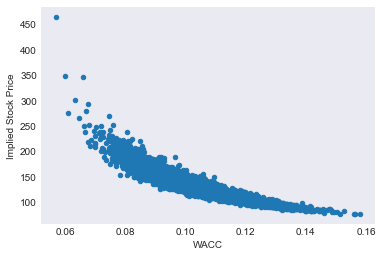

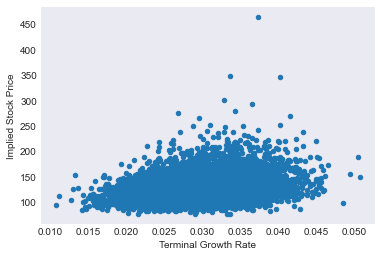

In [14]:
independent_columns = ["WACC","Terminal Growth Rate"]
for i in independent_columns:
    monte_carlo_df.plot(kind="scatter",y="Implied Stock Price",x=i)

## <a id='regression'>Linear Regression</a>

Seeking to quantify how changes in the independent variables impact the dependent variable we run a Regression below.

In [15]:
output_col = 'Implied Stock Price'
input_cols = ["WACC","Terminal Growth Rate"]

X = sm.add_constant(monte_carlo_df[input_cols])
y = monte_carlo_df[output_col]

mod = sm.OLS(y, X)
result = mod.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     Implied Stock Price   R-squared:                       0.911
Model:                             OLS   Adj. R-squared:                  0.911
Method:                  Least Squares   F-statistic:                 5.123e+04
Date:                 Sun, 17 Dec 2023   Prob (F-statistic):               0.00
Time:                         23:43:19   Log-Likelihood:                -33446.
No. Observations:                10000   AIC:                         6.690e+04
Df Residuals:                     9997   BIC:                         6.692e+04
Df Model:                            2                                         
Covariance Type:             nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                  268.0713      0.721    371.978      0.000     266.659     269.484
WACC                 -1684.6170      5.495   -306.563      0.000   -1695.389   -1673.845
Terminal Growth Rate  1295.9862     13.745     94.285      0.000    1269.042    1322.930
==============================================================================
Omnibus:                    15206.213   Durbin-Watson:                   2.003
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         18901414.611
Skew:                           9.075   Prob(JB):                         0.00
Kurtosis:                     215.212   Cond. No.                         202.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Below we Standarize the Coefficients to better compare and understand the effcts of the independent variables on the dependent one

In [16]:
result.params * monte_carlo_df.std()

Implied Enterprise Value          NaN
Implied Stock Price               NaN
Terminal Growth Rate         6.468816
WACC                       -21.032989
const                             NaN
dtype: float64

From the above Table we can see that the WACC carries the most impact when evvaluating the Implied Stock Price. A 1 Standard deviation increase in WACC will lower the implied Stock Price by $21

# <a id='residuals'>Model Prediciton vs Actuals : Multi - Linear Regression Model</a>

Below we plot the models predicted values compared to the implied values generated via the Monte Carlo Simulation. The Model does show signs of Heteroscedasticity seeing as how the residual variance is not constant and increases as Predicted Stock Price increases. In addition it is clear that a linear model does not fit the data appropiately

In [17]:
predicted_values = result.predict(X)

In [18]:
monte_carlo_df["Predicted Stock Price Multi Linear Regression"]= predicted_values

Text(0.5, 1.0, 'Actuals vs Predicted Values')

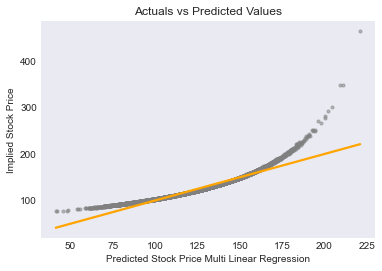

In [113]:
sns.regplot(data=monte_carlo_df, x="Predicted Stock Price Multi Linear Regression", y="Implied Stock Price",
            scatter_kws=dict(color='gray', s=10, alpha=0.5),
            line_kws=dict(color='orange'))
plt.title("Actuals vs Predicted Values")

To address this a polynomial regression will be conducted as well to find a better line fit for the data

# <a id='poli'>Multi Polynomial Regression</a>

We import sklearn to help with generating the order for the Polynomial Regression.

In [20]:
from sklearn.preprocessing import PolynomialFeatures

To find the appropiate order (degrees) you can calculate the BIC (Bayesian Information Criterion). You can also add the order to Linear Regression Models sns.regplot to get a rough idea on the polynomials order needed to fit the Data. BIC is best to avoid over fitting and selecting a too high polynomial. An external BIC calculation yielded a 7 order polynomial to have the lowest BIC value for this model.

In [100]:
polynomial_features= PolynomialFeatures(degree=7)

In [101]:
xp = polynomial_features.fit_transform(X)
xp.shape

(10000, 120)

In [102]:
mod_poli = sm.OLS(y, xp)
result_poli = mod_poli.fit()
result_poli.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     Implied Stock Price   R-squared:                       1.000
Model:                             OLS   Adj. R-squared:                  1.000
Method:                  Least Squares   F-statistic:                 3.931e+07
Date:                 Mon, 18 Dec 2023   Prob (F-statistic):               0.00
Time:                         00:01:34   Log-Likelihood:                 13023.
No. Observations:                10000   AIC:                        -2.598e+04
Df Residuals:                     9968   BIC:                        -2.575e+04
Df Model:                           31                                         
Covariance Type:             nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -6.707e+08   1.51e+09     -0.445      0.657   -3.63e+09    2.29e+09
x1         -7.528e+08   1.52e+09     -0.497      0.619   -3.72e+09    2.22e+09
x2          1.646e+09   7.73e+08      2.130      0.033    1.31e+08    3.16e+09
x3          4.421e+08   2.14e+08      2.063      0.039     2.2e+07    8.62e+08
x4         -7.521e+08   1.52e+09     -0.496      0.620   -3.72e+09    2.22e+09
x5          1.643e+09   7.65e+08      2.148      0.032    1.43e+08    3.14e+09
x6          4.355e+08   2.09e+08      2.088      0.037    2.66e+07    8.44e+08
x7          1.405e+08   1.23e+08      1.143      0.253      -1e+08    3.81e+08
x8          4.432e+07   3.23e+07      1.371      0.170    -1.9e+07    1.08e+08
x9         -1.088e+05   1.82e+07     -0.006      0.995   -3.58e+07    3.55e+07
x10        -7.522e+08   1.52e+09     -0.496      0.620   -3.72e+09    2.22e+09
x11         1.642e+09   7.65e+08      2.148      0.032    1.43e+08    3.14e+09
x12         4.354e+08   2.09e+08      2.088      0.037    2.67e+07    8.44e+08
x13         1.405e+08   1.23e+08      1.144      0.253      -1e+08    3.81e+08
x14         4.434e+07   3.23e+07      1.372      0.170    -1.9e+07    1.08e+08
x15        -4.009e+04   1.82e+07     -0.002      0.998   -3.57e+07    3.56e+07
x16        -1.005e+07    5.1e+05    -19.719      0.000   -1.11e+07   -9.05e+06
x17         2.746e+07   2.11e+06     13.020      0.000    2.33e+07    3.16e+07
x18        -3.869e+07   3.41e+06    -11.352      0.000   -4.54e+07    -3.2e+07
x19         9.329e+06    3.1e+06      3.013      0.003    3.26e+06    1.54e+07
x20         7.319e+08   1.51e+09      0.484      0.629   -2.23e+09     3.7e+09
x21        -1.233e+09   5.76e+08     -2.142      0.032   -2.36e+09   -1.05e+08
x22        -3.282e+08   1.58e+08     -2.079      0.038   -6.38e+08   -1.88e+07
x23        -6.957e+07   6.14e+07     -1.133      0.257    -1.9e+08    5.08e+07
x24        -2.317e+07   1.62e+07     -1.433      0.152   -5.48e+07    8.51e+06
x25         9.063e+05   9.11e+06      0.099      0.921    -1.7e+07    1.88e+07
x26        -1.004e+07    5.1e+05    -19.689      0.000    -1.1e+07   -9.04e+06
x27         2.746e+07   2.11e+06     13.019      0.000    2.33e+07    3.16e+07
x28        -3.869e+07   3.41e+06    -11.352      0.000   -4.54e+07    -3.2e+07
x29         9.329e+06    3.1e+06      3.013      0.003    3.26e+06    1.54e+07
x30         1.509e+08    4.7e+06     32.084      0.000    1.42e+08     1.6e+08
x31        -6.066e+08   2.37e+07    -25.620      0.000   -6.53e+08    -5.6e+08
x32         1.136e+09   5.63e+07     20.158      0.000    1.03e+09    1.25e+09
x33         -6.82e+08   7.13e+07     -9.566      0.000   -8.22e+08   -5.42e+08
x34         2.752e+08   8.63e+07      3.191      0.001    1.06e+08    4.44e+08
x35         7.319e+08   1.51e+09      0.484      0.629   -2.23e+09    

In [103]:
y_p2=result_poli.predict(xp)

In [114]:
monte_carlo_df["Predicted Stock Price Polynomial Regression"] = y_p2

# <a id='poliresiduals'>Model Prediciton vs Actuals : Multi Polynomial Regression Model</a>

Text(0.5, 1.0, 'Actuals vs Predicted Values')

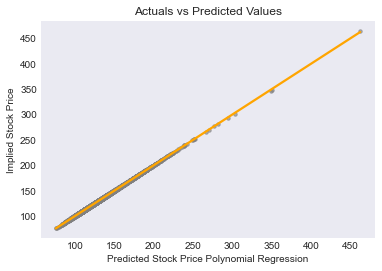

In [115]:
sns.regplot(data=monte_carlo_df, x="Predicted Stock Price Polynomial Regression", y="Implied Stock Price",
            scatter_kws=dict(color='gray', s=12, alpha=0.6),
            line_kws=dict(color='orange'))
plt.title("Actuals vs Predicted Values")